# Assignment 3 - Instagram Reverse Engineer

## Part A - Abstract

This research intends to reverse engineer Instagram's Claredon filter and apply it to some of our own images. We start by considering what might be the most reasonable areas to look in. We then investigate the histograms of original and filtered images, the pairwise differences between the two, and some implementations of sharpening, color alteration, and contrast to find a procedure that would achieve a close match to the Claredon filter's effects. Although our end result is not very visually similar to the Claredon filter, we can conclude that some sharpening and contrast enhancement is used in Instagram's Claredon filter.

## Part B and C - Methods and Code

In [336]:
%matplotlib inline
from matplotlib.axes import Subplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import ndarray
import skimage.io 
from skimage import img_as_float, img_as_ubyte
from skimage import color
from scipy.ndimage import convolve
import skimage.filters as filters
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import glob

In [138]:
# Set defaults
plt.rcParams['image.cmap'] = 'gray' # Display grayscale images in... grayscale.
plt.rcParams['image.interpolation'] = 'none' # Use nearest-neighbour
plt.rcParams['figure.figsize'] = 10, 10

In [197]:
# Import test images as ubytes
imgpaths = glob.glob("./images/*.JPG")
imgset = [img_as_ubyte(mpimg.imread(x)) for x in imgpaths]
# Import test images as floats
imgpaths2 = glob.glob("./images/*.JPG")
imgset2 = [img_as_float(mpimg.imread(x)) for x in imgpaths2]

### i. Analyze the histograms

In [23]:
# Plots a histogram of the image, splitting into individual channels if necessary.
def plot_multichannel_histo(img):
    if img.ndim == 2: # plot grayscale histo
        plt.hist(img.flatten(), 256,  range=(0,255), color='k', histtype='step')
    elif img.ndim == 3: # print rgb histo
        plt.hist(img.reshape(-1,3), 256,  range=(0,255), color=['r','g','b'],histtype='step')
    else: # Not an image
        print("Must pass a valid RGB or grayscale image")
    plt.xlim([0,255])

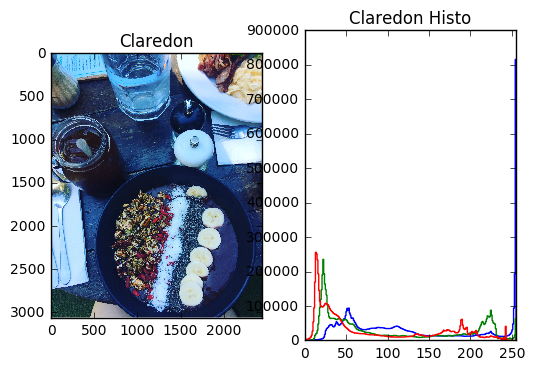

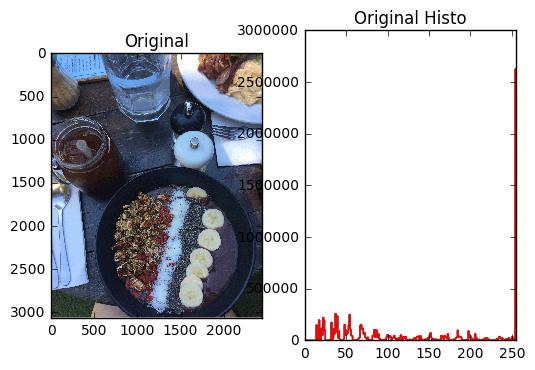

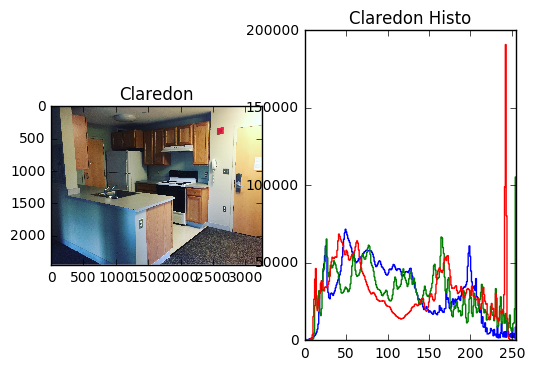

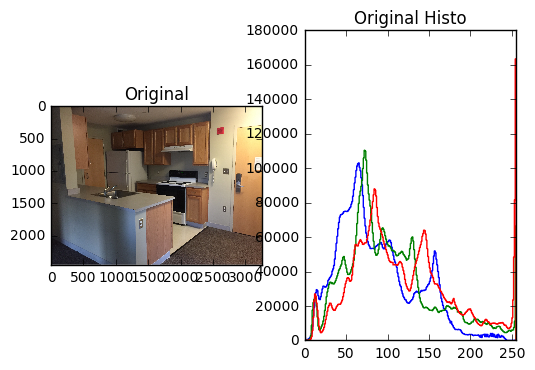

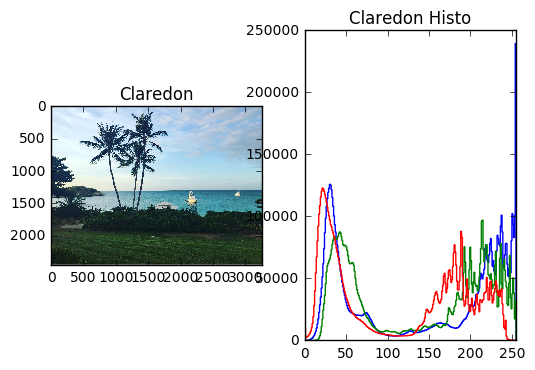

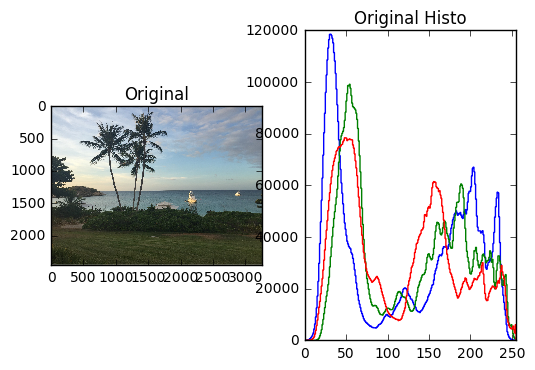

In [355]:
# Apply histogram to original images and images filtered with Instagram's Claredon filter
for i,img in enumerate(imgset):
    if (1 == i%2):
        imtitle = 'Original'
    else:
        imtitle = 'Claredon'
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title(imtitle)
    plt.imshow(img, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title(imtitle + ' Histo')
    plot_multichannel_histo(img)
    

Here we look at the histograms of 3 images and their filtered counterpart. There appears to be general raise in contrast, with an emphasis on blue values in particular.

## ii. Analyze pairwise differences

In [46]:
# Downsample an image by skipping indicies
def decimate_image(img, skip):
     return img[::skip,::skip]

In [47]:
# Find the absolute difference between two images. 
# Crops to the shared region between images.
def find_pairwise_difference(img_a, img_b):
    subset = np.minimum(img_a.shape, img_b.shape)
    img_a_subset = img_a[:subset[0], :subset[1]]
    img_b_subset = img_b[:subset[0], :subset[1]]
    return img_a_subset, img_b_subset, np.abs(img_a_subset - img_b_subset)

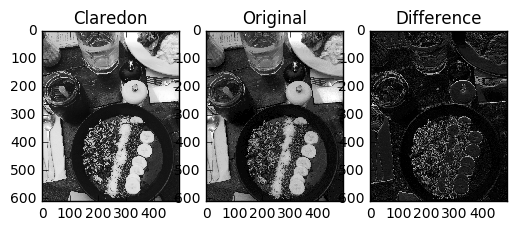

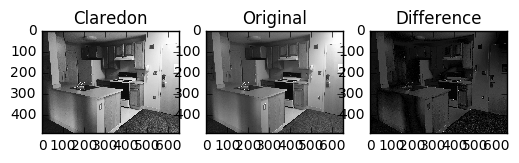

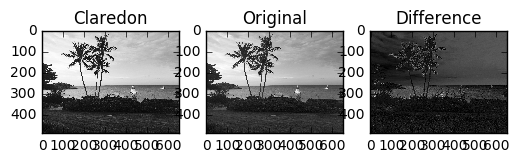

In [109]:
# Compare each image, pairwise, with its claredon counterpart.
for i in range(len(imgset)):
    if (0==i%2):
        decimg_a = img_as_float(color.rgb2grey(decimate_image(imgset[i], 5))) # downsample to make it easier to see graphs
        decimg_b = img_as_float(color.rgb2grey(decimate_image(imgset[(i+1) % len(imgset)], 5)))
        a, b, d = find_pairwise_difference(decimg_a, decimg_b)
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.title('Claredon')
        plt.imshow(a)
        plt.subplot(1, 3, 2)
        plt.title('Original')
        plt.imshow(b)
        plt.subplot(1, 3, 3)
        plt.title('Difference')
        plt.imshow(d)

Here we look at the pairwise differences between the images and their filtered counterparts by looking at them pixel by pixel. There appears to be sharpening happening because the edges are clearly more different than the other parts of the image.

### iii. Add Contrast

We saw from the histograms that is contrasting in play, we try to add some contrast to the image

In [356]:
origs = []
origs.append(Image.open("./images/acai_orig.JPG"))
origs.append(Image.open("./images/apt_orig.JPG"))
origs.append(Image.open("./images/aus_orig.JPG"))

In [357]:
# Apply a contrast enhancement filter to a copy of this image
def contrast(img):
    copy = img.copy()
    enhancer = ImageEnhance.Contrast(copy)
    return copy

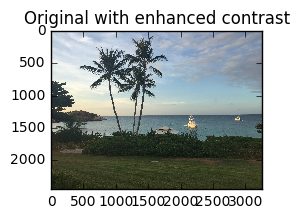

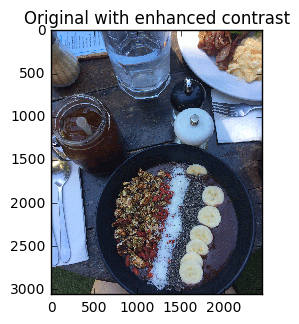

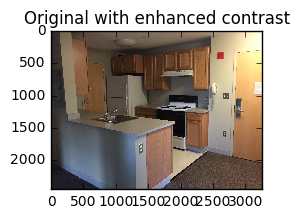

In [305]:
# Apply contrasting to all original images
for i in range(3):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original with enhanced contrast')
    img = contrast(origs[i])
    plt.imshow(img)

We see that the contrast adds a boldness that brings us closer to looking like the Claredon filter.

### iv. Bring out the blues

We also noted that there was higher levels on the blue values in the claredon images. We bring up the blues and reduce the reds. 

In [306]:
def blueup(img):
    # See Reference [1]
    imgcopy = img.copy()
    #adjusting the red lower red values to be diminished
    imgcopy[imgcopy[:,:,0] <= 0.05] /= 2
    #adjusting the green lower values to be diminished
    imgcopy[imgcopy[:,:,1] <= 0.05] /= 2
    #adjusting the blue values to be increased
    imgcopy[:,:,2] += 0.08
    imgcopy[:,:,2] /= 2
    return img

/Users/Lisa/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


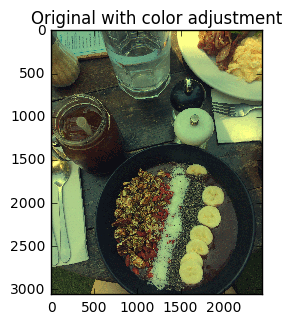

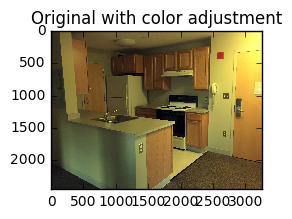

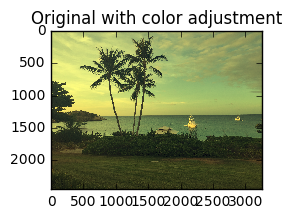

In [337]:
for i,img in enumerate(imgset2):
    if (1 == i%2):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title('Original with color adjustment')
        blue = blueup(img)
        plt.imshow(blue)
        skimage.io.imsave("./images/blued%d.JPG" % i, blue)

These values appear to be more yellow than the Claredon filter. In an unrelated note: these images have the appearance of an image viewed on a smartphone that is in "Night Mode"

### v. Sharpen

We noted that sharpening likely took place. Here we apply some sharpening to the images to get closer to the filtered images. 

In [325]:
#sharpen the image
def sharpener(img):
    img.convert('RGB').filter(ImageFilter.SHARPEN)
    return img

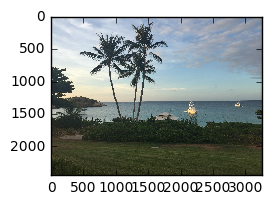

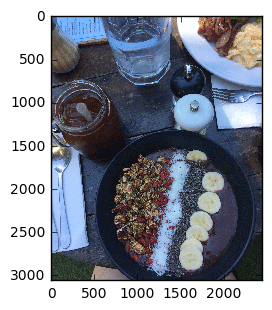

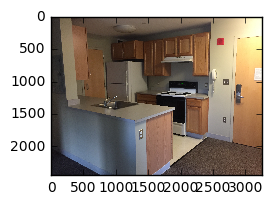

In [309]:
#apply sharpening to each image
for i in range(3):
        plt.figure()
        plt.subplot(1, 2, 2)
        plt.title('Original with sharpening')
        plt.imshow(sharpener(origs[i]))

The sharpening seems to bring the images into focus and improves clarity.

## Part D - Results

### i. Visual comparison between our filter and Instagram's

After performing the enhancements separately, we bring them together.

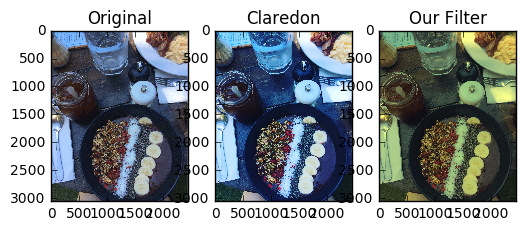

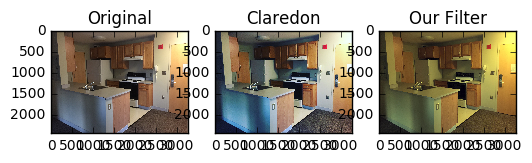

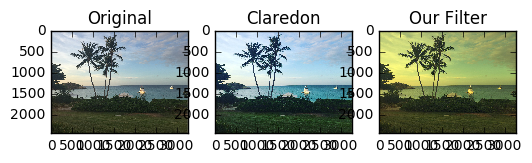

In [347]:
j = 0
filtered = []
for i in range(3):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(origs[i])
    plt.subplot(1, 3, 2)
    plt.title('Claredon')
    plt.imshow(imgset[j])
    plt.subplot(1, 3, 3)
    plt.title('Our Filter')
    im_blue = Image.open("./images/blued%s.JPG" % str(j+1))
    im_contrast = contrast(im_blue)
    im_sharpened = sharpener(im_contrast)
    plt.imshow(im_sharpened)
    filtered.append(im_sharpened)
    j += 2

### ii. Histogram comparison between our filter and Instagram's

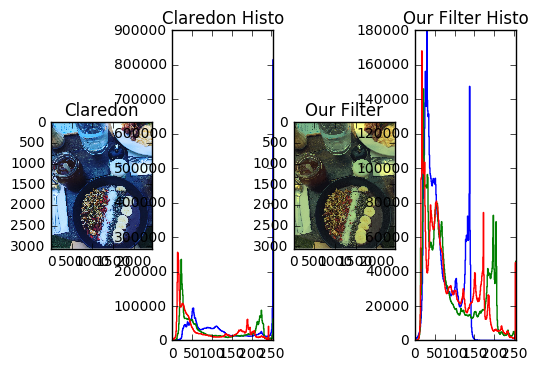

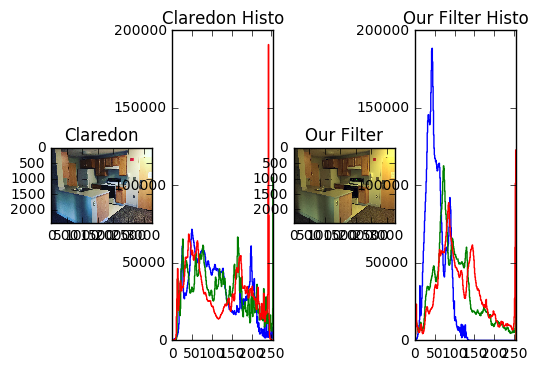

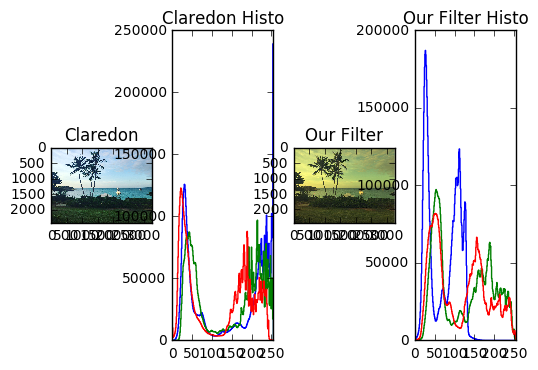

In [350]:
# Apply histograms to our filter and the claredon filter side by side.
k = 0
for i,img in enumerate(imgset):
        if (0 == i%2):
            imtitle = 'Claredon'
            plt.figure()
            plt.subplot(1, 4, 1)
            plt.title(imtitle)
            plt.imshow(img, cmap='gray')
            plt.subplot(1, 4, 2)
            plt.title(imtitle + ' Histo')
            plot_multichannel_histo(img)
            plt.subplot(1, 4, 3)
            plt.title('Our Filter')
            plt.imshow(filtered[k])
            plt.subplot(1, 4, 4)
            plt.title('Our Filter Histo')
            plot_multichannel_histo(img_as_ubyte(filtered[k]))
            k = k + 1

### iii. Pairwise differences between our filter and Instagram's

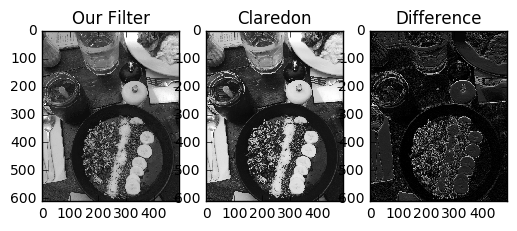

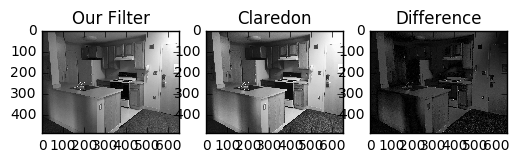

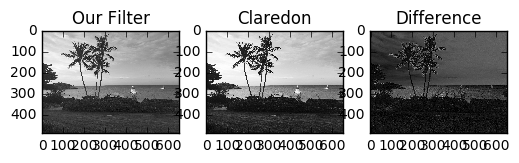

In [353]:
# Show a pairwise difference between our filter and Instagram's filter.
l = 0
for i in range(3):
    decimg_a = img_as_float(color.rgb2grey(decimate_image(img_as_ubyte(filtered[i]), 5))) # downsample to make it easier to see graphs
    decimg_b = img_as_float(color.rgb2grey(decimate_image(imgset[(l)], 5)))
    a, b, d = find_pairwise_difference(decimg_a, decimg_b)
    l = l + 2
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.title('Our Filter')
    plt.imshow(a)
    plt.subplot(1, 3, 2)
    plt.title('Claredon')
    plt.imshow(b)
    plt.subplot(1, 3, 3)
    plt.title('Difference')
    plt.imshow(d)

## Part E - Discussion 

Clearly, our filter is vastly different from the Claredon filter. Ours contains much more yellow and green tones than the claredon filter, which seems to somehow pull out aqua and indigo colors much more effectively than us. As we can see from the histograms, lower blue values on ours are much higher, while higher blue values on theirs are higher. Additionally, as we can see in the pairwise difference between our filter and theirs, it looks like we may have gone overboard on the sharpening to the point where the edges are almost more different than when compared to the original. Still, general idea of color transformation seems to apply, and the use of sharpening and  contrast at least appear to get the boldness of the Claredon filter, even if the colors are not correct. 

## Part F - References

[1] Code modified from provided Nashville_Instagram_Reverse_Engineering

[2] Code modified from Assignment 2 - Image Analysis.

[3] All images are mine.